## Import Packages


# Attention: 
The model fitting and recomendation list gathering should be repeated for the following to get the result : 
m1 : alpha 15 reg 0.1 factors 20 iterations 40 \\
m2 : alpha 40 reg 0.1 factors 20 iterations 40 \\
m3 : alpha 1 reg 0.1 factors 20 iterations 40 \\
**m4 : alpha 1 reg 0.01 factors 20 iterations 40** \\
m5 : alpha 1 reg 1 factors 20 iterations 40 \\
**otherwise please avoid re-run check the charts at the bottom instead**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/wm-project/"
%cd /content/drive/My\ Drive/wm-project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
02062021MusicRecommenderTeam3.ipynb
26052021MusicRecommenderTeam3.ipynb
all_predictions_scores.csv
als_predictions_scores1.csv
als_predictions_scores2.csv
als_predictions_scores.csv
back22052021MusicRecommenderTeam3.ipynb
df_artist.csv
df_general.csv
df_outlierDtected.csv
df_preprocessed.csv
df_test.csv
df_train_cleaned.csv
lookup_artist_names.csv
MusicRecommender_01_Preprocessing_backup.ipynb
MusicRecommender_01_Preprocessing.ipynb
MusicRecommender_02_Modelling.ipynb
MusicRecommender_03_ALS_tuning.ipynb
nrartist_df.csv
rec_train.csv
tasks.gsheet
userid-profile.tsv
userid-timestamp-artid-artname-traid-traname.tsv
/content/drive/My Drive/wm-project


In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 8.5MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406459 sha256=ce1b001dc96885cd474e2c6d721e49455771c143eba00e870472e7453e565c2c
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import hashlib
import pytz
import implicit
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.sparse import csr_matrix
# from surprise import SVD, NMF, KNNBasic, KNNWithMeans,Reader,Dataset
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import ndcg_score

## Import lookup tables

In [ ]:
# CSV imports
lookup_artist_names = pd.read_csv('lookup_artist_names.csv')

## Import train and test (02.06)

In [ ]:
trainset = pd.read_csv('df_train_cleaned.csv')
#testset = pd.read_csv('df_test.csv')

trainset = trainset.groupby('artist_id').filter(lambda x: len(x) >1)
tuning_train, tuning_test = train_test_split(trainset,
                                     test_size=0.25,
                                     random_state=41,
                                     stratify=trainset[['artist_id']])

In [ ]:
#check duplicates
pd.concat(g for _, g in tuning_train.groupby(['user_id', 'artist_id']) if len(g) > 1)
pd.concat(g for _, g in tuning_test.groupby(['user_id', 'artist_id']) if len(g) > 1)

,user_id,artist_id,absolute,user_total,relative,log,log_relative
78588,user_000047,1fda852b-92e9-4562-82fa-c52820a77b23,120,5651,0.021235,4.795791,3.101676
198252,user_000047,1fda852b-92e9-4562-82fa-c52820a77b23,120,5651,0.021235,4.795791,3.101676
154002,user_000180,1fda852b-92e9-4562-82fa-c52820a77b23,68,27139,0.002506,4.234107,1.254367
130080,user_000180,1fda852b-92e9-4562-82fa-c52820a77b23,68,27139,0.002506,4.234107,1.254367
75856,user_000202,1fda852b-92e9-4562-82fa-c52820a77b23,26,5663,0.004591,3.295837,1.721195
49377,user_000202,1fda852b-92e9-4562-82fa-c52820a77b23,26,5663,0.004591,3.295837,1.721195
176574,user_000771,66ea0139-149f-4a0c-8fbf-5ea9ec4a6e49,430,26938,0.015963,6.066108,2.831010
16287,user_000771,66ea0139-149f-4a0c-8fbf-5ea9ec4a6e49,430,26938,0.015963,6.066108,2.831010
44315,user_000835,e5257dc5-1edd-4fca-b7e6-1158e00522c8,16,26880,0.000595,2.833213,0.467023
201561,user_000835,e5257dc5-1edd-4fca-b7e6-1158e00522c8,16,26880,0.000595,2.833213,0.467023


In [ ]:
tuning_train = tuning_train.drop_duplicates() # 992 users

tuning_test = tuning_test.drop_duplicates() # 990 users

In [ ]:
tuning_train.shape[0]

161982

In [ ]:
#add relative counts
tuning_test['user_total'] = tuning_test.groupby('user_id').absolute.transform('sum')
tuning_test['relative'] = tuning_test['absolute'] / tuning_test['user_total']
tuning_test.drop(columns=['user_total'], inplace=True)

##ALS

In [ ]:
tuning_train_als = tuning_train.drop(columns=['relative', 'log', 'log_relative'])

In [ ]:
#for the latest split 01.06

tuning_train_als['userId'] = tuning_train_als['user_id'].astype('category').cat.codes
tuning_train_als['itemId'] = tuning_train_als['artist_id'].astype('category').cat.codes

import scipy.sparse as sparse
user_items = sparse.csr_matrix((tuning_train_als['absolute'].astype(float),(tuning_train_als['userId'], tuning_train_als['itemId'])))
item_users = sparse.csr_matrix((tuning_train_als['absolute'].astype(float),(tuning_train_als['itemId'], tuning_train_als['userId'])))

In [ ]:
matrix_size = user_items.shape[0]*user_items.shape[1] # Number of possible interactions in the matrix
num_listenings = len(user_items.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_listenings/matrix_size))
sparsity

98.27198353209332

In [ ]:
#model = implicit.als.AlternatingLeastSquares(factors = 500, iterations = 10)

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization= 1, iterations=40,use_cg=True,use_gpu=False)

# Calculate the confidence by multiplying it by our alpha value.(alpha value corresponds to the confidence metric)

alpha_val = 1
data_conf = (item_users * alpha_val).astype('double')

# We have used an alpha_val of 15 after performing some iterations with different alpha values
#Fit the model
model.fit(data_conf)

In [ ]:
def als_recommend(user_id, n=10):
  # userId=df_artsit.loc[df_artsit.user_id==user_id].iloc[0].userId
  userId=tuning_train_als.loc[tuning_train_als.user_id==user_id].iloc[0].userId
  recommended = model.recommend(userId, user_items,N = n,filter_already_liked_items = True)
  artists = []
  scores = []
  for item in recommended:
    idx, score = item
    # artists.append(df_artist.loc[df_artist.itemId == idx].iloc[0].artist_id)
    artists.append(tuning_train_als.loc[tuning_train_als.itemId == idx].iloc[0].artist_id)
    scores.append(score)
  recommendations = pd.DataFrame({'artist': artists, 'score': scores})
  return artists, scores
  # return recommendations

In [ ]:
als_recommend('user_000604', n=10)

(['4bb4e4e4-5f66-4509-98af-62dbb90c45c5',
  '148ddea2-6839-4354-8e2c-5dfadf136b7f',
  '44f42386-a733-4b51-8298-fe5c807d03aa',
  '2386cd66-e923-4e8e-bf14-2eebe2e9b973',
  '20883363-1ea4-4d72-ad72-c0e767038f3e',
  'e8374874-4178-4869-b92e-fef6bf30dc04',
  '23a03e33-a603-404e-bcbf-2c00159d7067',
  '65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab',
  'ac865b2e-bba8-4f5a-8756-dd40d5e39f46',
  '606bf117-494f-4864-891f-09d63ff6aa4b'],
 [1.2721288,
  1.2213497,
  1.1820173,
  1.1717968,
  1.1425104,
  1.1178901,
  1.105305,
  1.0952125,
  1.0834972,
  1.0803187])

# Evaluation

The current idea is to get recommendations based on train set. For each user we recommend the most potentially liked artists that has not been observed for that user in train set and later check in test set if the user will listen to the recommended artists.And judge the model performance based on precision and recall.

In [ ]:
!pip install ml_metrics
!pip install funcsigs
!pip install recmetrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp37-none-any.whl size=7845 sha256=6d374d6248f2af1df1a521b076b070a768a91bdb58abd7c3aaffa07fd07774f5
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics
     |████████████████████████████████| 11.8MB 8.8MB/s 
  Created wheel for recmetrics: filename=recmetrics-0.0.12-cp37-none-any.whl size=7257 sha256=90d5462cc5709509bc1b8b89a68c60e580dccf07afb52962dd9af2664042cc34
  Stored in directory: /root/.cache/pip/wheels/ee/1d/c8/290f4bf53768b9ffade43cd52522f95d173ff075a220f51531
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617658 sha256=b960b1e04df729340b54674c08dae48edda275f0095970cb9f88c00aa0bf6799
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built recmetrics scikit-surprise


In [ ]:
import recmetrics
#if error occurs:
#ImportError: cannot import name 'signature' from 'sklearn.utils.fixes' (/usr/local/lib/python3.7/dist-packages/sklearn/utils/fixes.py)
#change the plot.py - Instead of 'from sklearn.utils.fixes import signature' use 'from funcsigs import signature'

import ml_metrics as metrics

### save all prediction results 
- don't have to run this section
- all results are in 'all_predictions_scores.csv'

In [ ]:
# prepares the true liked artists from validation set for evaluation.
tuning_test_als = pd.DataFrame(tuning_test, columns=['user_id', 'artist_id', 'relative'])
tuning_test_als = tuning_test_als.groupby('user_id', as_index=False)['artist_id'].agg(
    {'true_artist': (lambda x: list(set(x)))})
# test_als = test_als.set_index('user_id')

In [ ]:
#21sec
# store als recommendations for all users
als_recs_m5 = [] 
als_score_m5 = []

for user in tuning_test_als.user_id:
    # print(user)
    artistList, scoreList = als_recommend(user, n=10)
    als_recs_m5.append(artistList)
    als_score_m5.append(scoreList)

tuning_test_als['als_recs_m5'] = als_recs_m5
tuning_test_als['als_score_m5'] = als_score_m5

In [ ]:
#2m37s
# store the true freq of predicted artists from als
tuning_test_als['als_true_score_m5'] = np.empty((len(tuning_test_als), 0)).tolist()

for i, row in tuning_test_als.iterrows():
  user = row['user_id']
  tuning_test_als.at[i, 'als_true_score_m5']= []
  for j in range(len(row['als_recs_m5'])):
    artistId = row['als_recs_m5'][j]
    if tuning_test.query("user_id==@user&artist_id==@artistId").relative.values.size == 0:
      true=0
    else: 
      true=tuning_test.query("user_id==@user&artist_id==@artistId").relative.values[0]
    tuning_test_als.at[i, 'als_true_score_m5'].append(true)

In [ ]:
tuning_test_als.to_csv('als_predictions_scores.csv', index=False)

### Import Results

In [ ]:
tuning_test_als.head()

,user_id,true_artist,als_recs_m1,als_score_m1,als_true_score_m1
0,user_000001,"[7f6a2b09-0666-410c-a5fb-b8cb111fdc8e, 5836869...","[b2a28d4a-5f5d-49f6-b944-9f5a4bffc4d9, 217794c...","[1.4399936, 1.3962826, 1.3861252, 1.377681, 1....","[0, 0, 0, 0, 0, 0.00026226068712300026, 0, 0, ..."
1,user_000002,"[0e0dd9da-5878-4c46-9a9a-6df43abb5c96, 30e0c00...","[792cec6c-2b5a-4076-beb5-669125ae58a2, fb50889...","[1.6053562, 1.5692683, 1.5678732, 1.5230596, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,user_000003,"[ab7ebf8c-059f-4071-93b1-dd3ae80d60b2, 9b21f67...","[87fc1871-b74e-4bf5-a00d-8a89c288008b, e097516...","[1.591824, 1.534075, 1.5170717, 1.4949564, 1.4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,user_000004,"[6655955b-1c1e-4bcb-84e4-81bcd9efab30, 004e5ee...","[2251b277-2dfb-4cf1-83f3-27e29f902440, c8bc9ad...","[1.5354233, 1.4886278, 1.4873111, 1.4620465, 1...","[0, 0.0004438526409232135, 0, 0, 0, 0.00355082..."
4,user_000005,"[65a8e571-8a08-433f-a5bf-ead38c269ea6, cea6cb4...","[6ed36b36-b2e0-4540-bc79-0348b744cb10, ae934b5...","[1.3414968, 1.3341563, 1.2493968, 1.2375746, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
#tuning_test_als = pd.read_csv('als_predictions_scores.csv')

In [ ]:
#for some reason the exported csv turned all list values into str type
#need to convert them to list for calculation
#cols=['true_artist', 'als_recs_m1', 'als_score_m1','als_true_score_m1']
#for column in cols:
#  test[column] = test[column].apply(lambda x: eval(x))

TypeError: ignored

In [ ]:
this lin is added to avoid accidental re-run which clears the charts

### mAP & mAR (@10)

In [ ]:
k_range = np.arange(1, 11)
true_artist = tuning_test_als.true_artist.values.tolist()
als_predictions = tuning_test_als.als_recs_m5.values.tolist()

als_mapk_m5 = []
als_mark_m5 = []

for K in k_range:
    als_mark_m5.extend([recmetrics.mark(true_artist,als_predictions, k=K)])
    als_mapk_m5.extend([metrics.mapk(true_artist, als_predictions, k=K)])

In [ ]:
eval_map = pd.DataFrame(
    {'@K': k_range,
     'als_map_m1': als_mapk_m1,
     'als_map_m2': als_mapk_m2,
     'als_map_m3': als_mapk_m3,
     'als_map_m4': als_mapk_m4,
     'als_map_m5': als_mapk_m5

    })
eval_mar = pd.DataFrame(
    {'@K': k_range,
     'als_mar_m1': als_mark_m1,
     'als_mar_m2': als_mark_m2,
     'als_mar_m3': als_mark_m3,
     'als_mar_m4': als_mapk_m4,
     'als_mar_m5': als_mapk_m5

})

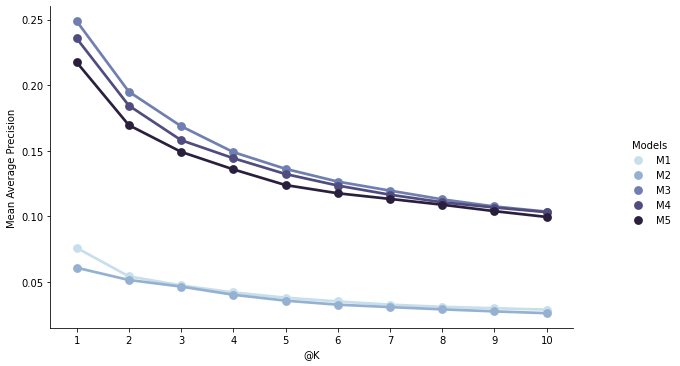

In [ ]:
df_map = eval_map.melt('@K', var_name='Models',  value_name='Mean Average Precision')
plot_map = sns.catplot(x='@K', y='Mean Average Precision', hue='Models', data=df_map, kind='point', palette='ch:s=.25,rot=-.25', 
                       height=5, aspect=8/5, legend_out = True)
# replace labels
labels = ['M1','M2','M3','M4','M5']
for t, l in zip(plot_map._legend.texts, labels): t.set_text(l)

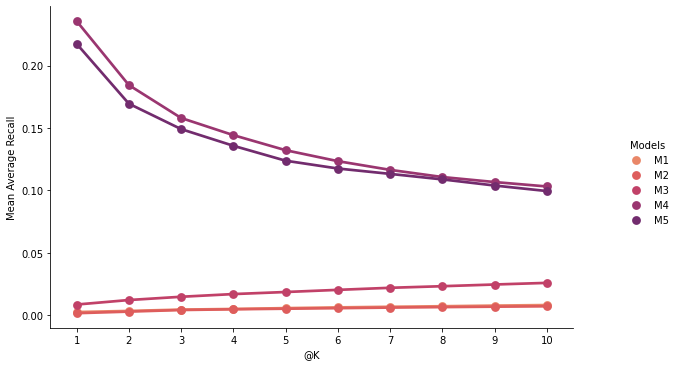

In [ ]:
df_mar = eval_mar.melt('@K', var_name='Models',  value_name='Mean Average Recall')
plot_mar = sns.catplot(x='@K', y='Mean Average Recall', hue='Models', data=df_mar, kind='point', palette='flare', 
                       height=5, aspect=8/5, legend_out = True)
# replace labels
labels = ['M1','M2','M3','M4','M5']
for t, l in zip(plot_mar._legend.texts, labels): t.set_text(l)

## nDCG

In [ ]:
score=[]
for i in range(len(test)):
  ndcg=ndcg_score([test.als_true_score.values[i]], [test.als_score.values[i]])
  score.append(ndcg)

ndcg_als = sum(score) / len(score)

In [ ]:
print('ndcg of als: {}'.format(ndcg_als))